# API service workflow

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import warnings
warnings.simplefilter('ignore')

from os import path
import sys
sys.path.append(path.abspath('..'))

In [4]:
import onnxruntime as ort
import numpy as np
import torch
import matplotlib.pyplot as plt
import jpeg4py as jpeg
import cv2 

from transforms import get_transforms
from predict_utils import matrix_to_string

In [18]:
ONNX_MODEL_PLATE_DET = '../models/plate-model.onnx'
ONNX_MODEL_PLATE_OCR = '../models/plate-ocr-model.onnx'
TEST_IMAGE_PATH = '../tests/images/img_1672.jpg'
TEST_IMAGE_PATH_2 = '../tests/images/img_1714.jpg'
VOCAB = '#&0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZÄÅÖÜĆČĐŠŽАБВГДЕЖЗИКЛМНОПРСТУФХЦЧШЭЮЯ'

BATCH_SIZE = 1

In [12]:
!pwd

/home/dmitriy/Nextcloud/Projects/Proj_courses/DeepSchool/hw-02/service_plates/notebooks


In [14]:
def onnx_preprocessing(
    image,
    image_size=(512, 512)
):
    """
    Convert numpy-image to array for inference ONNX Runtime model.
    """

    # resize
    image = cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_LINEAR)

    # normalize
    mean = np.array((0.485, 0.456, 0.406), dtype=np.float32) * 255.0
    std = np.array((0.229, 0.224, 0.225), dtype=np.float32) * 255.0
    denominator = np.reciprocal(std, dtype=np.float32)
    image = image.astype(np.float32)
    image -= mean
    image *= denominator

    # transpose
    image = image.transpose((2, 0, 1))[None]
    return image



## Models session initialization

In [15]:
# Available providers for ONNX
print(ort.get_available_providers())

['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'AzureExecutionProvider', 'CPUExecutionProvider']


In [16]:
# Session init

providers = [
    'CUDAExecutionProvider',
    'CPUExecutionProvider',
]

ort_session_det = ort.InferenceSession(
    ONNX_MODEL_PLATE_DET,
    providers=providers
)

ort_session_ocr = ort.InferenceSession(
    ONNX_MODEL_PLATE_OCR,
    providers=providers
)

## 1st model - get car plate crop

In [19]:
image = jpeg.JPEG(TEST_IMAGE_PATH_2).decode()

onnx_input = onnx_preprocessing(image, image_size=(512, 512))
onnx_input = np.concatenate([onnx_input] * BATCH_SIZE)
ort_inputs = {ort_session_det.get_inputs()[0].name: onnx_input}

In [20]:
# ONNX Runtime inference
ort_outputs = ort_session_det.run(None, ort_inputs)[0]
print(ort_outputs.shape)
pr_mask = (ort_outputs.squeeze().round())

(1, 1, 512, 512)


In [21]:
a = cv2.resize(image.copy(), (512,512), interpolation=cv2.INTER_LINEAR)
image.shape
a.shape

(3024, 4032, 3)

(512, 512, 3)

In [22]:
image.shape[0] / a.shape[0]

5.90625

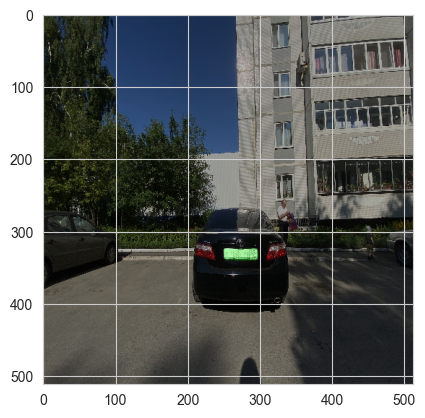

In [23]:
# Check output
test_image = cv2.resize(image.copy(), (512,512), interpolation=cv2.INTER_LINEAR)

green_masks = np.zeros(test_image.shape, dtype=np.uint8)
valid_area = np.argwhere(pr_mask > 0)
green_masks[valid_area[:,0], valid_area[:,1], 1] = 255
img_add = cv2.addWeighted(test_image, 0.7, green_masks, 0.3, 0)
        
plt.imshow(img_add, cmap='gray', vmin=0, vmax=255)

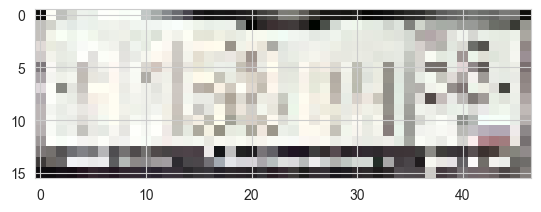

In [24]:
# Cropping an image
indexes = np.where(green_masks[:, :, 1] == 255)
x_min = indexes[1].min()
x_max = indexes[1].max()
y_min = indexes[0].min()
y_max = indexes[0].max()

crop_image_smal = test_image[y_min:y_max, x_min:x_max, :]
plt.imshow(crop_image_smal)

# Convert to full-size image
y_factor = image.shape[0] / test_image.shape[0]
x_factor = image.shape[1] / test_image.shape[1]
x_min_orig = int(x_min * x_factor)
x_max_orig = int(x_max * x_factor)
y_min_orig = int(y_min * y_factor)
y_max_orig = int(y_max * y_factor)

crop_image_orig = image[y_min_orig:y_max_orig, x_min_orig:x_max_orig, :]

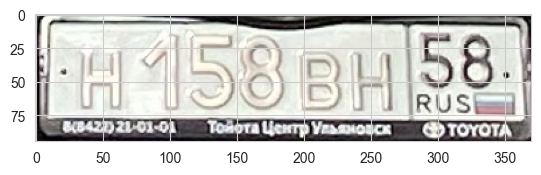

In [25]:
plt.imshow(crop_image_orig)

## 2nd model - OCR of car plate crops

In [26]:
transforms = get_transforms(width=416, height=64, text_size=10, vocab=VOCAB, postprocessing=True, augmentations=False)

In [27]:
onnx_input_ocr = transforms(image=crop_image_orig, text='')['image'][None]
onnx_input_ocr = np.concatenate([onnx_input_ocr] * BATCH_SIZE)
print(onnx_input_ocr.shape)

ort_inputs_ocr = {ort_session_ocr.get_inputs()[0].name: onnx_input_ocr}

(1, 3, 64, 416)


In [28]:
# ONNX Runtime inference
ort_outputs_ocr = ort_session_ocr.run(None, ort_inputs_ocr)[0]
print(ort_outputs_ocr.shape)

string_pred, _ = matrix_to_string(torch.from_numpy(ort_outputs_ocr), VOCAB)

(52, 1, 60)


['H158BH58']

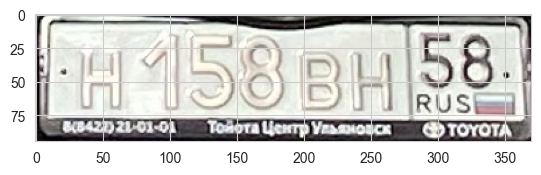

In [29]:
plt.imshow(crop_image_orig)
string_pred